In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import numpy as np
import requests
from itertools import combinations, permutations
from time import time
from numpy.random import random
from scipy.stats import spearmanr
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10,5

**load data from pickle files (data scraped in Clean_FantasyPros.ipynb)**

In [34]:
#list of experts
pkl_file = open('data/exp_order.pickle', 'rb')
exp_order = pickle.load(pkl_file)
pkl_file.close()
exp_order = [x.lower() for x in exp_order]

#top 25 experts' rankings
pkl_file = open('data/top25_dfs.pickle', 'rb')
top25_dfs = pickle.load(pkl_file)
pkl_file.close()

#top 25 experts' rankings
pkl_file = open('data/top_ranks.pickle', 'rb')
top_ranks = pickle.load(pkl_file)
pkl_file.close()

#ground truth rankings
pkl_file = open('data/ground_truth.pickle', 'rb')
ground_truth_wr = pickle.load(pkl_file)
pkl_file.close()

In [35]:
# 16 teams in each conference
nfc = [ 'DAL','NYG','PHI','WAS','CHI','DET','GB','MIN',
       'ATL','CAR','NO','TB','ARI','LAR','SF','SEA']

afc=['BUF','MIA','NE','NYJ','BAL','CIN','CLE','PIT',
         'HOU', 'IND','JAX','TEN', 'DEN','KC','OAK','LAC']

**load consensus rankings generated using our methods**

In [36]:
#read ILP aggregated rankings 
with open("data/agg.csv") as file_in:
    aggs = {}
    i=1
    for line in file_in:
        aggs[i]=[int(x) for x in line.strip().split(",")]
        
        i+=1
        
# read Fair-ILP aggregated rankings
with open("data/agg_par.csv") as file_in:
    fairs = {}
    i=1
    for line in file_in:
        fairs[i]=[int(x) for x in line.strip().split(",")]
        
        i+=1

**Compute parity scores **

In [37]:
#rank_parity method from the FARE repo gives the normalized absolute difference of the rpar scores for each group
# If you want to compute the pairwise advantage for each group separately you can use this method

from fare.metrics import _count_inversions,_merge_parity,_merge_eq

def rank_parity(y,groups):
    r = np.transpose([y,groups])
    r = r[r[:,0].argsort()]
    g= np.array(r[:,1], dtype=int)
    e0 = _count_inversions(g, 0, len(g)-1, _merge_parity, 0)[1]
    e1 = _count_inversions(g, 0, len(g)-1, _merge_parity, 1)[1]

    return e0,e1

In [38]:
groups = {}
for week in range(1,17):
    print(week)
    df = pd.read_csv("data/groups_"+str(week)+".csv",header=None)
    groups[week] = df[df.columns.values[0]].values

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [39]:
#get parity scores for expert ranks
df=pd.DataFrame(index=range(1,17))
e = list(top_ranks[1].keys())
for exp in e:
    pars = []
    for week in range(1,17):
        ranks = top_ranks[week]
        r = ranks[exp]['Rank']
        g = ranks[exp]['Team'].isin(nfc).astype(int)
        n_pairs = sum(g)*(len(g)-sum(g))
        a0,a1 = rank_parity(r,g)
        pars.append((a1-a0)/n_pairs)
    df[exp]=pars

In [40]:
#get parity scores for ground truth
ps = []
tmp = []
for week in range(1,17):
    gf = ground_truth_wr[week].join(top25_dfs[week]['Division'])
    r = gf['GT']
    g = gf['Division']
    a0,a1 = rank_parity(r,g)
    n_pairs = sum(g)*(len(g)-sum(g))
    ps.append((a1-a0)/n_pairs)
    tmp.append(a1-a0)
df['Ground Truth']=ps    

In [41]:
#get parity scores for ILP rankings
agg_pars = []
for week in aggs.keys():
#     g = top25_dfs[week]['Division']
    g = groups[week]
    r = aggs[week]
    e0,e1 = rank_parity(r,g)
    n_pairs = sum(g)*(len(g)-sum(g))
    agg_pars.append((e1-e0)/n_pairs)
    
df['ILP'] = agg_pars

In [42]:
#get parity scores for Fair-ILP rankings
fair_pars = []
for week in fairs.keys():
#     g = top25_dfs[week]['Division']
    g = groups[week]
    r = fairs[week]
    e0,e1 = rank_parity(r,g)
    n_pairs = sum(g)*(len(g)-sum(g))
    fair_pars.append((e1-e0)/n_pairs)
    
df['Fair_ILP'] = fair_pars

In [43]:
#Expert ranks mean parity score
df.drop(['ILP','Fair_ILP','Ground Truth'],axis=1).transpose().mean().mean()

0.1804386697079213

In [44]:
# GT mean parity score
df['Ground Truth'].mean()

0.11774728116387498

In [45]:
# ILP mean parity score
df['ILP'].mean()

0.26754806354745775

In [46]:
# ILP mean parity score
df['Fair_ILP'].mean()

0.1347599148788367

**Plot the parity scores over season**

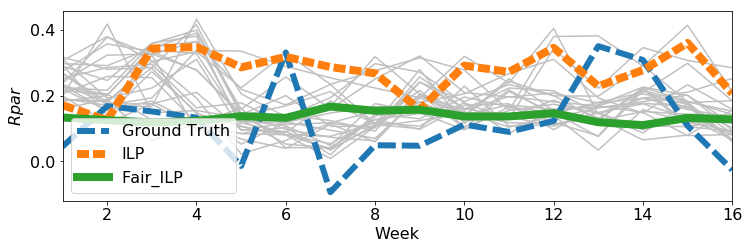

In [51]:
plt.rcParams['figure.figsize'] = 12,3.5
plt.rcParams['font.size'] = 16
df.drop(['Ground Truth','ILP'], axis=1).plot(legend=False, c='silver')
df['Ground Truth'].plot(legend=True,lw=6, linestyle=(0, (3, 1)))
axs = df['ILP'].plot(legend=True,lw=8, linestyle=(0, (1.5, 0.5)))
axs = df['Fair_ILP'].plot(legend=True,lw=8)
axs.set_ylabel(r'$Rpar$')
axs.set_xlabel('Week')
plt.savefig('figures/fantasy_weeks.pdf',bbox_inches='tight')
plt.savefig('figures/fantasy_weeks.png',bbox_inches='tight')